In [ ]:
# Figure 2: find example of gene that has credible
# novel isoforms  relatively highly expressed
# (maybe that also has high entropy)

# other things that would be interesting 
# involved in DTU
# population-specific


In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [5]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [46]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_counts')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [50]:
df = get_melted_pi_counts_table(ver='poder', min_t_cpm=None)
g_df = df[['gid', 'sample', 'population', 'g_counts']].drop_duplicates()
g_df['log_g_counts'] = np.log(g_df.g_counts+1)
df['log_t_tpm'] = np.log(df.t_tpm+1)

In [51]:
df.to_csv('241021_pi_counts_table_long.tsv', sep='\t', index=False)

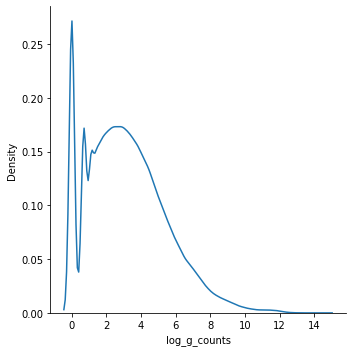

In [31]:
sns.displot(g_df, x='log_g_counts', kind='kde')

In [7]:
e_df = pd.read_csv('241021_entropy_summary.tsv', sep='\t')

In [25]:
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.258531
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.223182
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.200203
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.247052


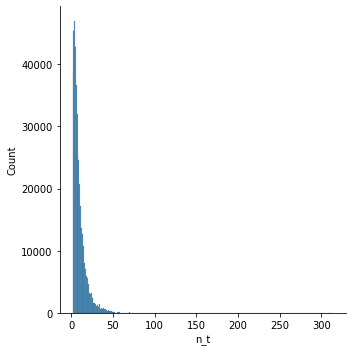

In [23]:
sns.displot(e_df, x='n_t', kind='hist', discrete=True)

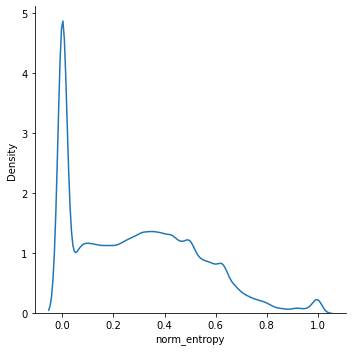

In [32]:
sns.displot(e_df, x='norm_entropy', kind='kde')

In [ ]:
sns.displot(e_df, x='entropy', kind='kde')

In [35]:
# add gene exp
e_df = e_df.merge(g_df, how='left', on=['gid', 'sample', 'population'])
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy,g_counts,log_g_counts
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729,717.00020,6.576470
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.258531,689.99997,6.538140
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.223182,2442.48200,7.801179
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.200203,370.99948,5.918892
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.247052,3302.99680,8.102888


In [75]:
# choose some random filts
min_n_t = 5
min_g_counts = 5000
min_entrop = 0.6

temp = e_df.loc[(e_df.n_exp_t>=min_n_t)&\
                (e_df.g_counts>=min_g_counts)&\
                (e_df.norm_entropy>=min_entrop)]

In [45]:
temp.head(20).tail(5)

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy,g_counts,log_g_counts
341840,ENSG00000196126.12,HAC3,HAC,24,2.004092,14,0.630604,13240.55756,9.491115
341855,ENSG00000196126.12,MPC2,MPC,24,1.972548,11,0.620678,5587.50031,8.628466
341861,ENSG00000196126.12,PEL4,PEL,24,1.984415,13,0.624412,7729.92550,8.952984
341863,ENSG00000196126.12,PEL6,PEL,24,1.992560,12,0.626975,5470.83564,8.607369
347589,ENSG00000197111.16,AJI5,AJI,46,2.644228,32,0.690644,5517.78482,8.615913


In [53]:
gid = 'ENSG00000197111.16'
sample = 'AJI5'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm
5199754,transcript_41129,ENSG00000197111.16,AJI5,0.199301,63.1876,AJI,5517.78482,4.161810
5199750,transcript_41124,ENSG00000197111.16,AJI5,0.137407,43.5643,AJI,5517.78482,3.796933
5199758,transcript_41135,ENSG00000197111.16,AJI5,0.127108,40.2991,AJI,5517.78482,3.720841
5199746,transcript_41120,ENSG00000197111.16,AJI5,0.118369,37.5284,AJI,5517.78482,3.651396
5199756,transcript_41131,ENSG00000197111.16,AJI5,0.050130,15.8935,AJI,5517.78482,2.826929
5199760,transcript_41137,ENSG00000197111.16,AJI5,0.048933,15.5141,AJI,5517.78482,2.804215
5199795,transcript_41279,ENSG00000197111.16,AJI5,0.039728,12.5956,AJI,5517.78482,2.609746
5199752,transcript_41126,ENSG00000197111.16,AJI5,0.036697,11.6346,AJI,5517.78482,2.536439
5199775,transcript_41202,ENSG00000197111.16,AJI5,0.036005,11.4151,AJI,5517.78482,2.518913
5199755,transcript_41130,ENSG00000197111.16,AJI5,0.032512,10.3078,AJI,5517.78482,2.425493


In [42]:
gid = 'ENSG00000008517.19'
sample = 'AJI5'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts
5209710,transcript_65780,ENSG00000008517.19,AJI5,0.184285,56.9849,AJI,5381.60351
5209730,transcript_65810,ENSG00000008517.19,AJI5,0.135444,41.8822,AJI,5381.60351
5209760,transcript_65865,ENSG00000008517.19,AJI5,0.108997,33.7040,AJI,5381.60351
5209751,transcript_65848,ENSG00000008517.19,AJI5,0.078527,24.2823,AJI,5381.60351
5209763,transcript_65869,ENSG00000008517.19,AJI5,0.066368,20.5225,AJI,5381.60351
5209765,transcript_65872,ENSG00000008517.19,AJI5,0.057666,17.8316,AJI,5381.60351
5209771,transcript_65881,ENSG00000008517.19,AJI5,0.044962,13.9031,AJI,5381.60351
5209721,transcript_65797,ENSG00000008517.19,AJI5,0.039575,12.2373,AJI,5381.60351
5209782,transcript_65906,ENSG00000008517.19,AJI5,0.034886,10.7874,AJI,5381.60351
5209745,transcript_65840,ENSG00000008517.19,AJI5,0.032961,10.1922,AJI,5381.60351


In [64]:
gid = 'ENSG00000205542.11'
sample='CEU4'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
4250562,transcript_185237,ENSG00000205542.11,CEU4,0.984280,15534.40000,CEU,178066.225925,9.650877,transcript_185237,True
4250554,transcript_185218,ENSG00000205542.11,CEU4,0.007182,113.35800,CEU,178066.225925,4.739334,transcript_185218,False
4250563,transcript_185239,ENSG00000205542.11,CEU4,0.005390,85.06340,CEU,178066.225925,4.455084,transcript_185239,False
4250560,transcript_185234,ENSG00000205542.11,CEU4,0.001386,21.88000,CEU,178066.225925,3.130263,transcript_185234,False
4250559,transcript_185233,ENSG00000205542.11,CEU4,0.000647,10.20830,CEU,178066.225925,2.416655,transcript_185233,False
4250555,transcript_185225,ENSG00000205542.11,CEU4,0.000295,4.66235,CEU,178066.225925,1.733839,transcript_185225,False
4250548,transcript_185204,ENSG00000205542.11,CEU4,0.000199,3.14084,CEU,178066.225925,1.420899,transcript_185204,False
4250556,transcript_185228,ENSG00000205542.11,CEU4,0.000174,2.74185,CEU,178066.225925,1.319580,transcript_185228,False
4250553,transcript_185216,ENSG00000205542.11,CEU4,0.000165,2.60541,CEU,178066.225925,1.282435,transcript_185216,False
4250561,transcript_185235,ENSG00000205542.11,CEU4,0.000108,1.70428,CEU,178066.225925,0.994836,transcript_185235,False


In [65]:
gid = 'ENSG00000205542.11'
sample='LWK2'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
477780,transcript_185237,ENSG00000205542.11,LWK2,0.785075,7872.54000,LWK,122184.908008,8.971263,transcript_185237,True
477772,transcript_185218,ENSG00000205542.11,LWK2,0.204594,2051.62000,LWK,122184.908008,7.626872,transcript_185218,False
477781,transcript_185239,ENSG00000205542.11,LWK2,0.006637,66.54940,LWK,122184.908008,4.212859,transcript_185239,False
477778,transcript_185234,ENSG00000205542.11,LWK2,0.000922,9.24480,LWK,122184.908008,2.326770,transcript_185234,False
477777,transcript_185233,ENSG00000205542.11,LWK2,0.000895,8.97522,LWK,122184.908008,2.300104,transcript_185233,False
477773,transcript_185225,ENSG00000205542.11,LWK2,0.000493,4.94769,LWK,122184.908008,1.783003,transcript_185225,False
477766,transcript_185204,ENSG00000205542.11,LWK2,0.000375,3.75661,LWK,122184.908008,1.559535,transcript_185204,False
477779,transcript_185235,ENSG00000205542.11,LWK2,0.000310,3.10656,LWK,122184.908008,1.412586,transcript_185235,False
477771,transcript_185216,ENSG00000205542.11,LWK2,0.000296,2.97077,LWK,122184.908008,1.378960,transcript_185216,False
477774,transcript_185228,ENSG00000205542.11,LWK2,0.000215,2.15868,LWK,122184.908008,1.150154,transcript_185228,False


In [14]:
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [20]:
mt_df.structural_category.unique()

array(['FSM', 'ISM', 'NNC', 'Fusion', 'NIC', 'Intergenic', 'Antisense',
       'Genic'], dtype=object)

In [56]:
df = df.merge(mt_df[['isoform', 'pop_spec_t']], 
              how='left', left_on='tid', right_on='isoform')

In [60]:
ps_df = df.loc[(df.pop_spec_t==True)&(df.t_tpm>0)]

In [69]:
ps_df.sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
4250562,transcript_185237,ENSG00000205542.11,CEU4,0.984280,15534.4000,CEU,178066.225925,9.650877,transcript_185237,True
477780,transcript_185237,ENSG00000205542.11,LWK2,0.785075,7872.5400,LWK,122184.908008,8.971263,transcript_185237,True
4830990,transcript_185237,ENSG00000205542.11,PEL6,0.283456,2694.1200,PEL,74350.825174,7.899198,transcript_185237,True
2484206,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL5,0.882661,162.1430,PEL,4102.162347,5.094627,transcript_121711,True
5121204,transcript_185237,ENSG00000205542.11,AJI5,0.007243,90.7089,AJI,217944.227790,4.518619,transcript_185237,True
1903778,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,HAC6,0.065990,83.9182,HAC,28120.879530,4.441688,transcript_121711,True
5701632,transcript_185237,ENSG00000205542.11,YRI7,0.007150,76.0733,YRI,143859.232420,4.344757,transcript_185237,True
767994,transcript_185237,ENSG00000205542.11,CEU5,0.006399,62.7178,CEU,171148.395200,4.154464,transcript_185237,True
3234813,transcript_185237,ENSG00000205542.11,LWK5,0.006230,57.8203,LWK,133218.236250,4.074487,transcript_185237,True
1783743,transcript_185237,ENSG00000205542.11,HAC1,0.004987,57.1612,HAC,230705.249600,4.063218,transcript_185237,True


In [70]:
ps_df.loc[ps_df.tid!='transcript_185237'].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
2484206,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL5,0.882661,162.1430,PEL,4102.162347,5.094627,transcript_121711,True
1903778,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,HAC6,0.065990,83.9182,HAC,28120.879530,4.441688,transcript_121711,True
1033136,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL4,0.078483,54.5856,PEL,9986.682380,4.017924,transcript_121711,True
5732057,transcript_263514,ENSG00000103187.8,YRI7,0.879014,46.0281,YRI,708.000000,3.850745,transcript_263514,True
4805918,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL6,0.323085,42.0320,PEL,1017.696829,3.761944,transcript_121711,True
742922,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,CEU5,0.949118,36.8762,CEU,678.467590,3.634323,transcript_121711,True
3350802,transcript_109376,ENSG00000034510.6,PEL1,0.001757,27.6479,PEL,230741.381750,3.355080,transcript_109376,True
3064373,transcript_118713,ENSG00000185651.16,MPC3,0.029893,27.5079,MPC,9239.001630,3.350181,transcript_118713,True
5166459,transcript_298478,ENSG00000134326.12,AJI5,0.995134,23.5007,AJI,411.000000,3.198702,transcript_298478,True
5966513,transcript_118713,ENSG00000185651.16,CEU2,0.023455,22.5681,CEU,11685.028100,3.159894,transcript_118713,True


In [67]:
mt_df.loc[mt_df.isoform=='transcript_185237']

,associated_transcriptid.v,trx_per_asstrx_count_antisense,trx_per_asstrx_count_full-splice_match,trx_per_asstrx_count_fusion,trx_per_asstrx_count_genic,trx_per_asstrx_count_incomplete-splice_match,trx_per_asstrx_count_intergenic,trx_per_asstrx_count_novel_in_catalog,trx_per_asstrx_count_novel_not_in_catalog,associated_geneid.v,...,start,end,strand,discovered_transcripts_per_gene,old_associated_geneid.v,old_associated_gene_biotype,existsFSMinGene,existsFSMinTranscript,filter,pop_spec_t
370254,novel,11799,0,15719,2592,0,7960,53706,126986,ENSG00000205542.11,...,12975985,12977226,+,55,ENSG00000205542.11,protein_coding,True,False,pass,True


In [ ]:
ps_df.loc[ps_df.tid=='transcript_185237'].sort_values(by=['population', 't_tpm'])

In [74]:
gid = 'ENSG00000103187.8'
tid = 'transcript_263514'
sample = 'YRI7'
df.loc[(df.tid==tid)].sort_values(by=['population', 't_tpm'])

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
943526,transcript_263514,ENSG00000103187.8,AJI4,0.000000e+00,0.000000e+00,AJI,99.000000,0.000000e+00,transcript_263514,True
6167378,transcript_263514,ENSG00000103187.8,AJI1,0.000000e+00,0.000000e+00,AJI,136.000000,0.000000e+00,transcript_263514,True
1669061,transcript_263514,ENSG00000103187.8,AJI2,3.536738e-09,1.813440e-08,AJI,65.000000,1.813440e-08,transcript_263514,True
5151629,transcript_263514,ENSG00000103187.8,AJI5,3.061228e-02,1.002600e+00,AJI,570.000000,6.944463e-01,transcript_263514,True
3990773,transcript_263514,ENSG00000103187.8,AJI3,3.262411e-01,1.170820e+00,AJI,46.999900,7.751050e-01,transcript_263514,True
3845666,transcript_263514,ENSG00000103187.8,AJI6,3.226788e-01,4.044250e+00,AJI,219.000100,1.618249e+00,transcript_263514,True
4716308,transcript_263514,ENSG00000103187.8,CEU1,0.000000e+00,0.000000e+00,CEU,191.000000,0.000000e+00,transcript_263514,True
6022271,transcript_263514,ENSG00000103187.8,CEU2,0.000000e+00,0.000000e+00,CEU,255.000000,0.000000e+00,transcript_263514,True
4280987,transcript_263514,ENSG00000103187.8,CEU4,4.857713e-07,1.188330e-05,CEU,276.000268,1.188323e-05,transcript_263514,True
1378847,transcript_263514,ENSG00000103187.8,CEU3,2.467391e-01,5.687070e+00,CEU,230.000000,1.900176e+00,transcript_263514,True
